
# F.A.I.R. data management in **CRC 1333** *project INF*

## INF03 - SAXS workflow with AnIML

---

> Authors: Torsten Giess, Selina Itzigehl  
> Last modified: 24.09.2021


### **Abstract** <a class="anchor" name="abstract"></a>

lorem ipsum

### **Table of Contents** <a class="anchor" name="table_of_contents"></a>

- [Abstract](#abstract)
- [Introduction](#introduction)
- [Workflow](#workflow)
    - [User guide](#user_guide)
    - [Preparation](#preparation)
    - [Data extraction](#data_extraction)
    - [Visualisation](#visualisation)
    - [Analysis](#analysis)
    - [Results](#results)
- [Discussion](#discussion)
- [Outlook](#outlook)
- [Bibliography](#bibliography)

### **Introduction** <a class="anchor" name="introduction"></a>

lorem ipsum

### **Workflow** <a class="anchor" name="workflow"></a>

#### **User guide** <a class="anchor" name="user_guide"></a>

lorem ipsum

#### **Preparation** <a class="anchor" name="preparation"></a>

lorem ipsum

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd
from lmfit.models import LorentzianModel


def lorentzian( y0, a, w, x, xc ):
    # y0=offset, xc=center, w=FWHM, a=area
    return y0 + (2*a/np.pi)*(w/(4*(x-xc)^2 + w^2))

def LorentzFit (x, y, fig, add, q):
    model = LorentzianModel()

    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    res_fit = []

    for item in (result.fit_report()).split():
        try:
            res_fit.append(float(item))
        except ValueError:
            pass
        
    q.append(res_fit[9])
    
    add.plot(x, result.best_fit, linestyle = ':', color = 'blue', label = 'best fit')

    return q


# plot of SAXS data
def SAXSplt (pfad, label, color):
    a = pd.read_table(pfad, delimiter = '   ', usecols=[0,1], names = ['q', 'I'], header=5, skipfooter=496, engine = 'python')
    
    q = a['q']
    I = a['I']
    
    plt.plot(q, I, linestyle='-', marker=',', label = label, color = color)
    plt.yscale('log')          
    plt.xlabel('$q$ / $\mathrm{nm}^{-1}$')
    plt.ylabel('$I$ / a.u.')
    plt.xlim(0,5)
    plt.ylim(0.0001,2)    
    plt.legend(frameon=False)
    save_name = label + '.pdf'
    plt.savefig(save_name)
    plt.show()    

#calculation of lattice parameter (+ all intermediary values)
def SAXScalc(qCholpal, qSampleItem):
    dLit=[52.49824535,26.24912267,17.49941512] #literature d-values
    data = [] # list for writing to csv file
    
    qCholpalLit = [ScatteringVector(dLitItem) for dLitItem in dLit]
    
    slope, intercept = np.polyfit(qCholpal, qCholpalLit, 1)  # linear fit measured vs. literature q-values
        
    qKorr = [LinReg(slope, i, intercept) for i in qSampleItem]
    
    dMeas = [LatticePlane(qKorrItem) for qKorrItem in qKorr]
    data.append(dMeas)
    
    dRatio = [LatticeRatio(dMeasItem, dMeas[0]) for dMeasItem in dMeas[1:]]
    data.append(dRatio)
    
    if IsHexagonal(dRatio) == True:
        h = [1,1,2,2,3]
        k = [0,1,0,1,0]
        a_hex = []
        for i, dMeasItem in enumerate(dMeas):
            a_i = HexagonalLatticeParameter(dMeas[i], h[i], k[i])
            a_hex.append(a_i)
        a = ['hexagonal', (np.mean(a_hex))]
        data.append(a)
        
    elif IsCubic(dRatio) == True:
        h = [1,1,2,2,2]
        k = [0,1,0,1,2]
        l = [0,1,0,1,2]
        a_cub = []
        for i, dMeasItem in enumerate(dMeas):
            a_i = CubicLatticeParameter(dMeas[i], h[i], k[i], l[i])
            a_cub.append(a_i)
        a = ['cubic', (np.mean(a_cub))]
        data.append(a)
        
    elif IsLamellar(dRatio) == True:
        print('lamellar')
        
    else:
        a = ['not determinable', '-']
        data.append(a)
        
    return data

# Test if hexagonal, cubic oder lamellar
def IsHexagonal(arbList):
    H1 = [(1/np.sqrt(3)), (1/np.sqrt(4)), (1/np.sqrt(7)), (1/np.sqrt(9))]
    for i, arbListItem in enumerate(arbList):
        if (abs(arbList[i]-H1[i])) < 0.03:
            hexagonal = True
        else: 
            hexagonal = False
    return hexagonal
        

def IsCubic(arbList):
    Q = [(1/np.sqrt(2)), (1/np.sqrt(3)), (1/np.sqrt(4)), (1/np.sqrt(5))]
    i=0
    for i, arbListItem in enumerate(arbList):
        if (abs(arbList[i]-Q[i])) < 0.03:
            cubic = True
        else:
            cubic = False
    return cubic


def IsLamellar(arbList):
    L = [(1/2), (1/3), (1/4), (1/5)]
    for i, ArbListItem in enumerate(arbList):
        if (abs(arbList[i]-L[i])) < 0.03:
            lamellar = True
        else:
            lamellar = False
    return lamellar
        

def HexagonalLatticeParameter(d, h, k):
    a_hex = (d*((h + k + (h * k))*(np.sqrt(4/3))))
    return a_hex

def CubicLatticeParameter(d, h, k, l):
    a_cub = (d*(np.sqrt((h**2)+(k**2)+(l**2))))
    return a_cub

def LinReg(m, x, b):
    y = m*x + b
    return y

def ScatteringVector(d):
    q = (2*np.pi)/(d/10)
    return q

def LatticePlane(q):
    d = (2*np.pi)/q
    return d

def LatticeRatio(d, d_0):
    d_ratio = d/d_0
    return d_ratio

#### **Data extraction** <a class="anchor" name="data_extraction"></a>

lorem ipsum

In [6]:
path = "C:/Users/Selly/Documents/GitHub/SAXS-converter/Jupyter/datasets" 
files = os.listdir(path)


#### Cholesteryl Palmitate ####
a = pd.read_table('datasets/CholPal_210713[7]1.pdh', delimiter = '   ', usecols=[0,1], names = ['q', 'I'], header=5, skipfooter=496, engine = 'python')
q = a['q']
I = a['I']

# peak 1: 1.0<q<1.3 // peak 2: 1.5<q<3 // peak 3: 3<q<4

a1_idx = a.index[(a['q'] > 0.6) & (a['q'] < 1.5)].tolist()
a1 = a.loc[a1_idx]
q1 = np.array(a1['q'].tolist())
I1 = np.array(a1['I'].tolist())

a2_idx = a.index[(a['q'] > 1.5) & (a['q'] < 3)].tolist()
a2 = a.loc[a2_idx]
q2 = np.array(a2['q'].tolist())
I2 = np.array(a2['I'].tolist())

a3_idx = a.index[(a['q'] > 3) & (a['q'] < 4)].tolist()
a3 = a.loc[a3_idx]
q3 = np.array(a3['q'].tolist())
I3 = np.array(a3['I'].tolist())


#### Samples ####
# Measured and fitted q-values from samples
dataSample = [i for i in files if i.endswith('_lorentz.txt')]
# Measurement data for plotting
dataPlot = [i for i in files if i.endswith('[7].pdh')]

# make list of lists with measured q-values (from Lorentz-Fit)
qSample = []
for dataSampleItem in dataSample:
    name = 'datasets/' + dataSampleItem
    a = pd.read_table(name, delimiter = '\t', usecols=[1,2], names = ['parameter', 'I'], header=1)
    xc = a.loc[a['parameter'] == 'xc']
    peak = xc['I'].tolist()
    qSample.append(peak)

#### **Visualisation** <a class="anchor" name="visualisation"></a>

lorem ipsum

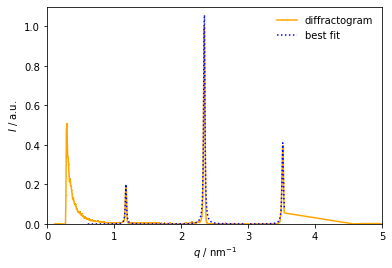

[1.17560174, 2.34572076, 3.51747273]


In [7]:
qCholpal = []

fig = plt.figure()
add = fig.add_subplot(1,1,1)
add.plot(q,I, marker = ',', color = 'orange', label = 'diffractogram')

plt.xlabel('$q$ / $\mathrm{nm}^{-1}$')
plt.ylabel('$I$ / a.u.')
plt.xlim(0,5)
plt.ylim(0, (max(I)+(0.1*max(I))))

LorentzFit(q1,I1, fig, add, qCholpal)
plt.legend(frameon=False)
LorentzFit(q2,I2, fig, add, qCholpal)
LorentzFit(q3,I3, fig, add, qCholpal)

plt.show()

print(qCholpal)

#### **Analysis** <a class="anchor" name="analysis"></a>

lorem ipsum

In [8]:
calc = []
for qSampleItem in qSample:
    calc.append(SAXScalc(qCholpal, qSampleItem))


dataEvaluation=[]
for i, dataPlotItem in enumerate(dataPlot):
    name = [os.path.splitext(dataPlotItem)[0]]
    calcItem = calc[i]
    for i, calcItemItem in enumerate(calcItem):  
        for i, calcItemItemItem in enumerate(calcItemItem):
            name.append(calcItemItem[i])
    dataEvaluation.append(name)
    
print(dataEvaluation)

[['SI06_210623[7]', 11.456351992002793, 6.272619808185863, 5.567939138347864, 0.5475233139278995, 0.4860132738793826, 'hexagonal', 15.93875095437864], ['SI09_210628[7]', 10.897635627242092, 6.328021930113078, 5.323749109021016, 0.5806784284743548, 0.4885233174536152, 'hexagonal', 15.599696213111486], ['SI16_210803[7]', 11.438019655997953, 6.375274072276465, 5.553602863124402, 0.5573756877514502, 0.48553884589734575, 'hexagonal', 16.039193699160215], ['SI17_210811[7]', 10.281393204300349, 5.896791989413495, 5.113781699335573, 0.5735401683642516, 0.49738217357513925, 'hexagonal', 14.702929961902184], ['SI19_210825[7]', 14.257821490418817, 7.565268939475811, 5.822286651052519, 0.530604829395545, 0.4083573815933287, 'not determinable', '-']]


#### **Results** <a class="anchor" name="results"></a>

lorem ipsum

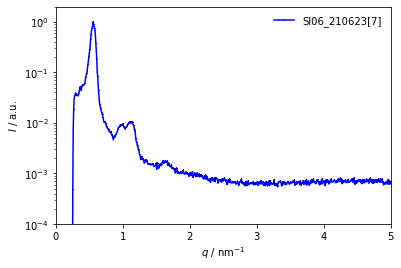

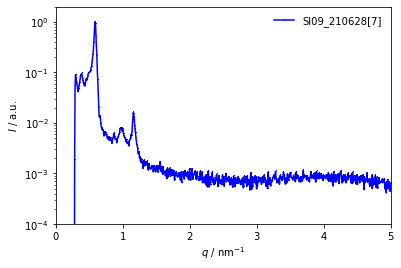

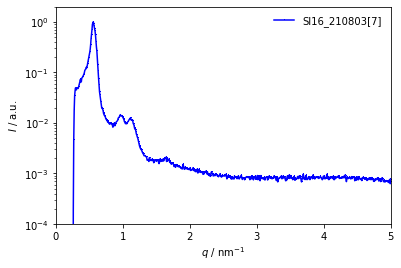

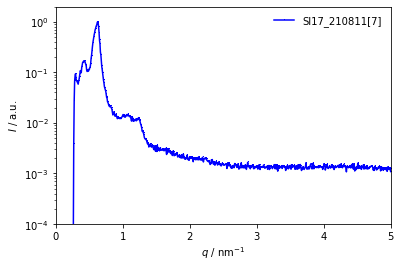

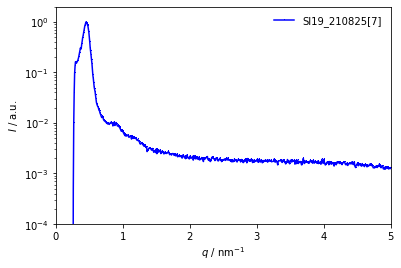

In [9]:
# write calculated data into tsv file
header = ['sample', '$d_1$', '$d_2$', '$d_3$', '$d_2/d_1$', '$d_3/d_1$','LLC phase', 'a']

with open('datasets/test2.tsv', 'w') as f:
    wr = csv.writer(f, delimiter='\t')
    wr.writerow(header)
    wr.writerows(dataEvaluation)
    f.close()


# plot and save all data
for dataPlotItem in dataPlot:
    name2 = 'datasets/' + dataPlotItem
    SAXSplt(name2, os.path.splitext(dataPlotItem)[0], 'blue')

### **Discussion** <a class="anchor" name="discussion"></a>

lorem ipsum

### **Outlook** <a class="anchor" name="outlook"></a>

lorem ipsum

### **Bibliography** <a class="anchor" name="bibliography"></a>

lorem ipsum